<a href="https://colab.research.google.com/github/RileyWClarke/BiancoGroup/blob/master/Notebooks/fftfilter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


#Potentially useful astropy stuff
import astropy
import astropy.io.ascii as ascii
from astropy.table import Table
from astropy.io import fits
from astropy.stats import LombScargle
from astropy.stats import sigma_clipped_stats
from astropy.stats import sigma_clip
from astropy.modeling import powerlaws
from astropy import constants as const
from astropy import units as u

#For reading in and organizing data
import pandas as pd
import requests
import json

#Misc
import scipy
from scipy import stats
from scipy.optimize import curve_fit
from collections import Counter
import itertools


#Making Figures look nice
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 18

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Data Collection/Cleaning

In [ ]:
k2targs = pd.read_csv('/content/gdrive/My Drive/hlsp_k2varcat_k2_lightcurve_c00-c04_kepler_v2_catalog.csv')
k2targs.head()

,# ID,Campaign,Class,Class Probs (DSCUT,EA,EB,GDOR,Noise,OTHPER,RRab),Anomaly Score
0,202059070,0,Noise,0.004195,0.120507,0.016615,0.005925,0.604636,0.246088,0.002034,0.023891
1,202059073,0,Noise,0.000000,0.000760,0.000037,0.000180,0.851359,0.147664,0.000000,0.003344
2,202059074,0,Noise,0.000086,0.003688,0.000218,0.007253,0.547118,0.441569,0.000067,0.083032
3,202059078,0,Noise,0.000523,0.002839,0.000332,0.000105,0.888648,0.107552,0.000000,0.000000
4,202059080,0,Noise,0.038219,0.082267,0.022758,0.058409,0.614507,0.078915,0.104926,0.136364


In [ ]:
targets = k2targs[['# ID', ' Campaign']].values
targets

array([[202059070,         0],
       [202059073,         0],
       [202059074,         0],
       ...,
       [211203438,         4],
       [211203556,         4],
       [211203589,         4]])

In [ ]:
urls = ['https://archive.stsci.edu/missions/k2/lightcurves/c'
        +str(target[1])+'/'+str(target[0])[0:4]+'00000/'
        +str(target[0])[4:6]+'000/ktwo'+str(target[0])
        +'-c0'+str(target[1])+'_llc.fits' for target in targets]
urls[::5000]

['https://archive.stsci.edu/missions/k2/lightcurves/c0/202000000/59000/ktwo202059070-c00_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c0/202000000/91000/ktwo202091770-c00_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c1/201200000/35000/ktwo201235947-c01_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c1/201500000/09000/ktwo201509462-c01_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c1/201600000/98000/ktwo201698027-c01_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c1/201800000/93000/ktwo201893576-c01_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c2/203500000/89000/ktwo203589087-c02_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c2/204700000/54000/ktwo204754843-c02_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c3/205900000/32000/ktwo205932262-c03_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c3/206000000/89000/ktwo206089354-c03_llc.fits',


In [ ]:
#Read in arrays via astropy.fits.open
def urls_to_dict(urls, campaign):
  d = {}
  for j, url in enumerate(urls):
    if url[51] == campaign:
      try:
        with fits.open(url, mode="readonly") as hdulist:
          d["k2bjds{0}".format(j)] = hdulist[1].data['TIME'] 
          d["pdcsap_flux{0}".format(j)] = hdulist[1].data['PDCSAP_FLUX']
          d["pdcsap_flux_err{0}".format(j)] = hdulist[1].data['PDCSAP_FLUX_ERR']

      except: 
        print('Loop '+str(j)+' : File not found')

  return d

In [ ]:
d0 = urls_to_dict(urls[0:1000], campaign='0')

Loop 111 : File not found
Loop 129 : File not found
Loop 140 : File not found
Loop 229 : File not found
Loop 648 : File not found
Loop 649 : File not found
Loop 650 : File not found
Loop 651 : File not found
Loop 652 : File not found
Loop 653 : File not found
Loop 654 : File not found
Loop 655 : File not found
Loop 656 : File not found
Loop 657 : File not found
Loop 658 : File not found
Loop 659 : File not found
Loop 660 : File not found
Loop 661 : File not found
Loop 662 : File not found
Loop 663 : File not found
Loop 664 : File not found
Loop 665 : File not found
Loop 666 : File not found
Loop 667 : File not found
Loop 668 : File not found
Loop 669 : File not found


In [ ]:
#How many objects did we grab total?
len(d0)/3

974.0

In [ ]:
nanseries = []
for filename in d0:
  nanseries.append(d0[filename])

In [ ]:
np.shape(nanseries)

(2922, 3753)

In [ ]:
!pwd

/content


In [ ]:
!cd gdrive

In [ ]:
!ls

gdrive	sample_data


In [ ]:
np.save('gdrive/My Drive/nanseries', nanseries)

In [ ]:
nanseries = np.load('gdrive/My Drive/nanseries.npy')

In [ ]:
bjds = nanseries[::3]
fluxes = nanseries[1::3]
fluxerrs = nanseries[2::3]

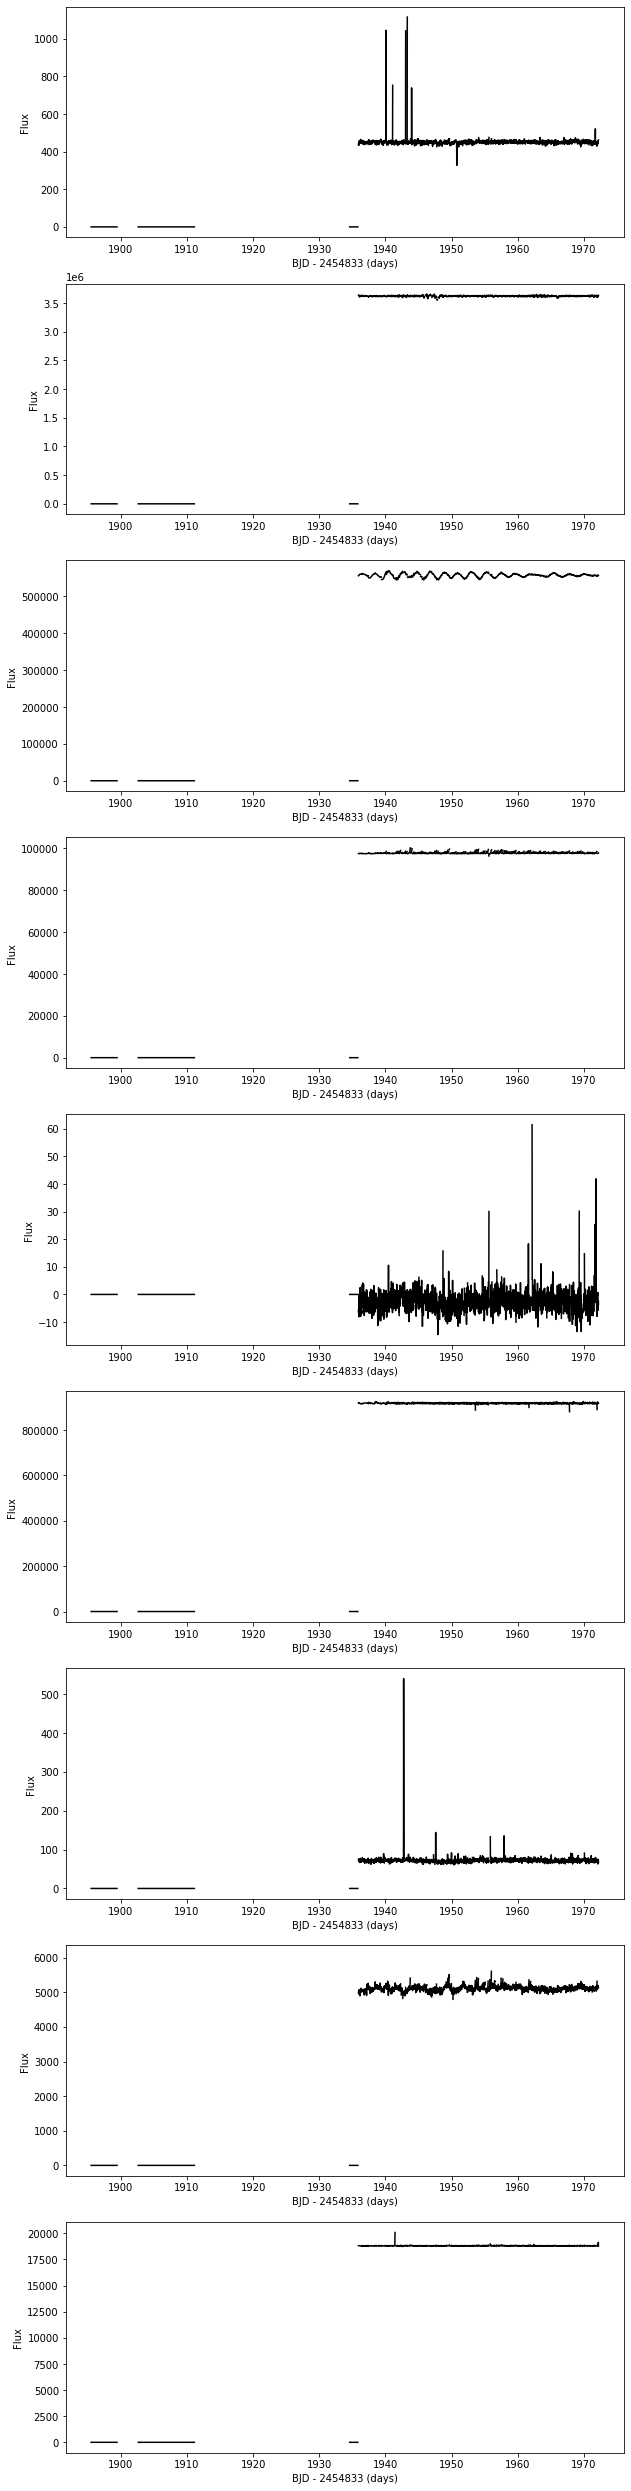

In [ ]:
fig, axes = plt.subplots(9, figsize=(10,45))
p = 0
for i in range(0,900,100):
  #fluxes[i] = (fluxes[i] - np.nanmean(fluxes[i])) / np.nanstd(fluxes[i])
  axes[p].plot(bjds[i], fluxes[i], c='k')
  axes[p].set_ylabel('Flux')
  axes[p].set_xlabel('BJD - 2454833 (days)')
  p += 1
plt.savefig('gdrive/My Drive/nanseries.png', dpi=100)


In [ ]:
#Remove initial data gap
def trunc(bjds, fluxes, fluxerrs, start):
  l1 = []
  l2 = []
  l3 = []
  for i in range(len(bjds)):
    l1.append(bjds[i][start:])
    l2.append(fluxes[i][start:])
    l3.append(fluxerrs[i][start:])

  return l1, l2, l3

In [ ]:
start = np.where(np.abs(fluxes[0]) >= 1)[0][0]
bjds, fluxes, fluxerrs = trunc(bjds, fluxes, fluxerrs, start)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


In [ ]:
#Normalize flux values
for i in range(len(fluxes)):
  fluxes[i] = (fluxes[i] - np.nanmean(fluxes[i])) / np.nanstd(fluxes[i])

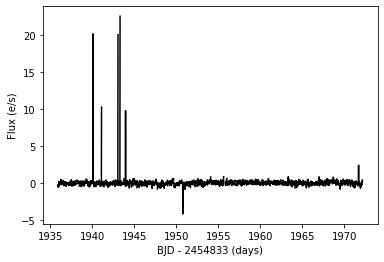

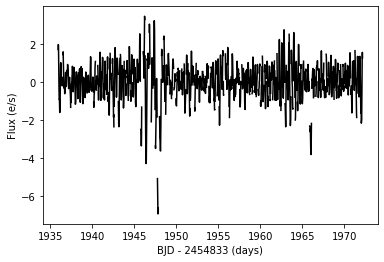

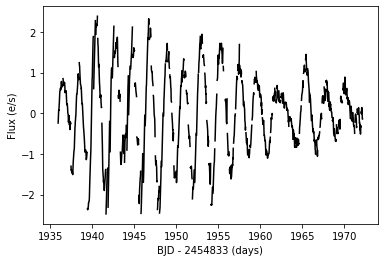

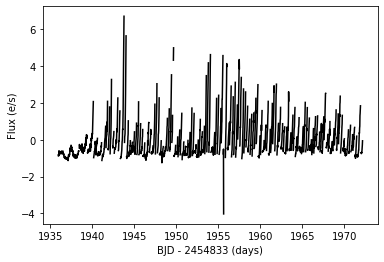

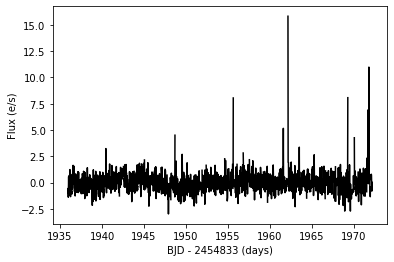

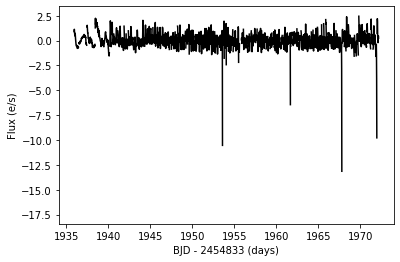

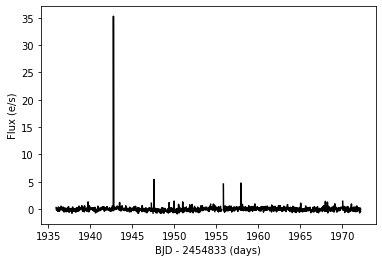

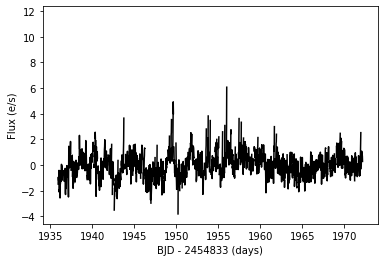

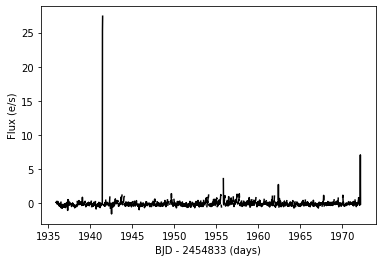

In [ ]:
for i in range(0,900,100):
  plt.plot(bjds[i], fluxes[i], c='k')
  plt.xlabel('BJD - 2454833 (days)')
  plt.ylabel('Flux (e/s)')
  plt.show()

In [ ]:
#Test for NaNs:
a = []
for j in range(len(bjds)):
  a.append(np.any(np.isnan(bjds[j]) == True))
  a.append(np.any(np.isnan(fluxes[j]) == True))
  a.append(np.any(np.isnan(fluxerrs[j]) == True))
np.any(a)#If NaNs exist, this returns True

True

In [ ]:
#Build list of # of consectutive nans + their indices in series
bjd_gaps = []
flux_gaps = []
fluxerr_gaps = []

for bjd in bjds:
  nancount = 0
  for i in range(len(bjd)):
    if (np.isnan(bjd[i]) == True) and (np.isnan(bjd[i+1]) == False):
      nancount += 1
      bjd_gaps.append(nancount)
      nancount = 0

    if (np.isnan(bjd[i]) == True) and (np.isnan(bjd[i+1]) == True):
      nancount += 1

for flux in fluxes:
  nancount = 0
  for i in range(len(flux)):

    if (np.isnan(flux[i]) == True) and (np.isnan(flux[i+1]) == False):
      nancount += 1
      flux_gaps.append(nancount)
      nancount = 0

    if (np.isnan(flux[i]) == True) and (np.isnan(flux[i+1]) == True):
      nancount += 1

for fluxerr in fluxerrs:
  nancount = 0
  for i in range(len(fluxerr)):
    if (np.isnan(fluxerr[i]) == True) and (np.isnan(fluxerr[i+1]) == False):
      nancount += 1
      fluxerr_gaps.append(nancount)
      nancount = 0

    if (np.isnan(fluxerr[i]) == True) and (np.isnan(fluxerr[i+1]) == True):
      nancount += 1

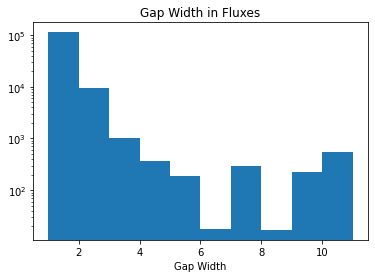

In [ ]:
plt.hist(flux_gaps)
plt.yscale('log')
plt.xlabel('Gap Width')
plt.title('Gap Width in Fluxes')
plt.savefig('nanhist', dpi=200)

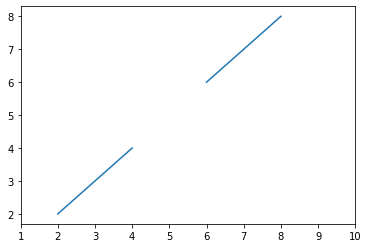

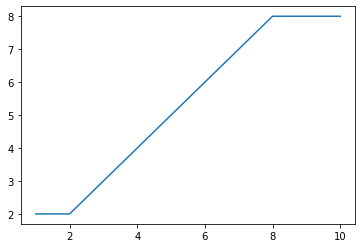

In [ ]:
#Simple linear interpolation model:
x = [1,2,3,4,5,6,7,8,9,10]
y = [np.nan,2,3,4,np.nan,6,7,8,np.nan,np.nan]

plt.plot(x,y)
plt.xlim(1,10)
plt.show()

if np.isnan(y[0]) == True:
  for i,j in enumerate(y):
    if np.isnan(j) == False:
      y[:i] = np.full(i, j)
      break
    else:
      pass

if np.isnan(y[-1]) == True:
  for i,j in enumerate(y[::-1]):
    if np.isnan(j) == False:
      y[-i:] = np.full(i, j)
      break
    else:
      pass

bools = np.isnan(y)
edges = np.diff(bools)
edgeindx = np.where(~(edges == 0))[0]+1

for i, edge in enumerate(edgeindx):
  if i%2 == 0:

    a, b = np.polyfit((x[edge-1], x[edgeindx[i+1]]), (y[edge-1], y[edgeindx[i+1]]) , 1)
    ynew = a * np.array(x[edge:edgeindx[i+1]]) + b

  else:
    continue
  
  y[edge:edgeindx[i+1]] = ynew

plt.plot(x,y)

In [ ]:
def lin_interp_nans(time, flux):
    newflux = np.copy(flux)

    #if series tip/tail is nan, replace with first/last real value:

    if np.isnan(newflux[0]) == True:
      for i,j in enumerate(newflux):
        if np.isnan(j) == False:
          newflux[:i] = np.full(i, j)
          break
        else:
          pass

    if np.isnan(newflux[-1]) == True:
      for i,j in enumerate(newflux[::-1]):
        if np.isnan(j) == False:
          newflux[-i:] = np.full(i, j)
          break
        else:
          pass

    #patching:
    bools = np.isnan(newflux)
    edges = np.diff(bools)
    edgeindx = np.where(~(edges == 0))[0]+1
    
    for i, edge in enumerate(edgeindx):
    
      if i%2 == 0:
        
        a, b = np.polyfit( (time[edge-1], time[edgeindx[i+1]]),
                           (flux[edge-1], flux[edgeindx[i+1]]), deg = 1)
        
        patch = a * np.array(time[edge:edgeindx[i+1]]) + b 

      else:
        continue

      newflux[edge:edgeindx[i+1]] = patch
      
    return newflux

In [ ]:
#Interpolate the flux arrays:
for i, flux in enumerate(fluxes):
  fluxes[i] = lin_interp_nans(bjds[i], flux)

In [ ]:
#Test for NaNs:
a = []
for j in range(len(fluxes)):
  a.append(np.any(np.isnan(fluxes[j]) == True))
np.any(a)#If NaNs exist, this returns True

False

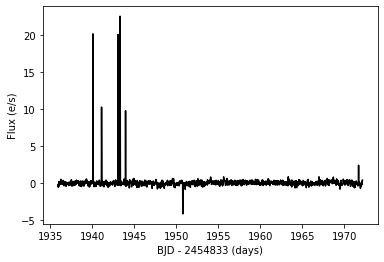

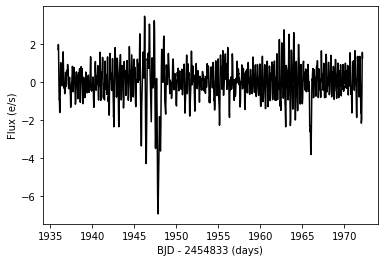

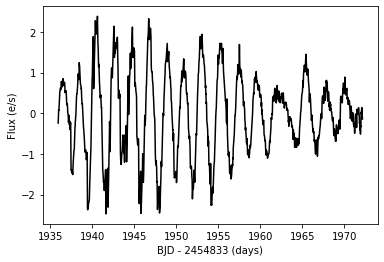

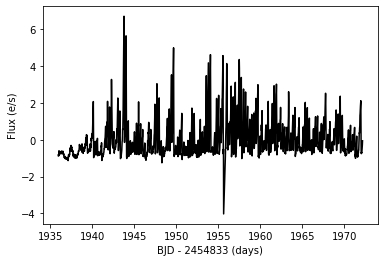

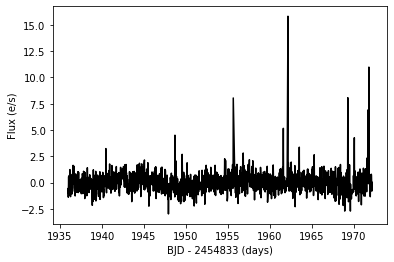

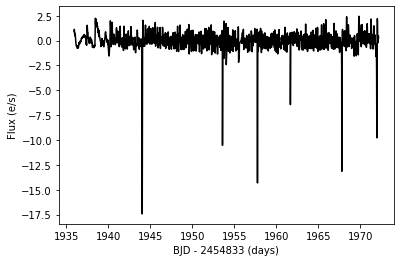

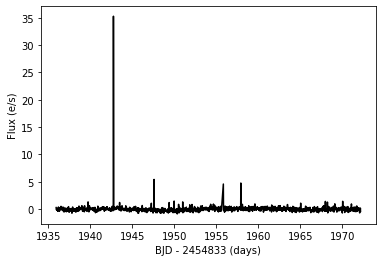

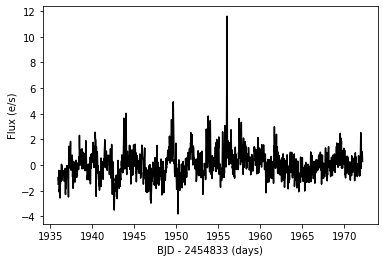

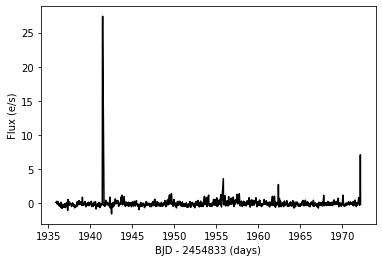

In [ ]:
for i in range(0,900,100):
  plt.plot(bjds[i], fluxes[i], c='k')
  plt.xlabel('BJD - 2454833 (days)')
  plt.ylabel('Flux (e/s)')
  plt.show()

# FFT Filtering

In [ ]:
def invgaussian(m, s, x):
    g = -np.exp(-(m-x)**2 / s**2) + 1 
    return g

In [ ]:
def bandpass_ifft(t, flux, low_cutoff, high_cutoff, sample=1, 
                  M=None, inv_box=False, gf_sig = 1, Filter='box', Plot=''):
    """Bandpass filtering on a real signal using inverse FFT
    
    Inputs
    =======
    
    X: 1-D numpy array of floats, the real time domain signal (time series) to be filtered
    Low_cutoff: float, frequency components below this frequency will not pass the filter (physical frequency in unit of Hz)
    High_cutoff: float, frequency components above this frequency will not pass the filter (physical frequency in unit of Hz)
    sample: float, the sampling frequency of the signal (physical frequency in unit of Hz)    
    M: idk lmao
    inv_box: If using box filter, setting inv=True filters out frequencies outside the box
    Filter: Default filter is box, can choose 'Gaussian' also
    
    Notes
    =====
    1. The input signal must be real, not imaginary nor complex
    2. The Filtered_signal will have only half of original amplitude. Use abs() to restore. 
    3. In Numpy/Scipy, the frequencies goes from 0 to F_sample/2 and then from negative F_sample to 0. 
    
    """        
    #perform fft
    spectrum = np.fft.rfft(flux) 
    freq = np.fft.rfftfreq(len(flux), sample)
    freq_sort = np.sort(spectrum)
    
    #calculate the index of the cut off points
    lc = np.abs(freq) < Low_cutoff
    hc = np.abs(freq) > High_cutoff
    between = ~(lc + hc)
    
    ps = np.abs(spectrum)**2
    if ('PS' in Plot) or ('All' in Plot):
      plt.plot(freq, ps)
      plt.title("power spectrum")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Power Spectral Density')
      #plt.xlim(0,100)
      #plt.savefig('Figures/spec.png', bbox_inches='tight', pad_inches=0.5)
      plt.show()

    if ('DFT' in Plot) or ('All' in Plot):
      plt.plot(freq, spectrum)
      #plt.plot(freq[between], spectrum[between], alpha=0.5)
      plt.title("real fourier transform ")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Amplitude')
      #plt.xlim(0,100)
      #plt.savefig('Figures/fft.png', bbox_inches='tight', pad_inches=0.5)
      plt.show()
    
    
    
    if Filter == 'box':
    
      #filtered_spectrum = spectrum.copy()
    
      if inv_box == True:
        x_1 = np.arange(0, Low_cutoff, 0.1)
        x_2 = np.arange(High_cutoff, np.max(freq), 0.1)
        plt.plot(freq, spectrum)
        plt.fill_between(x_1, [plt.ylim()[0]] * len(x_1), 
                     [plt.ylim()[1]] * len(x_1), color='r', alpha=0.3)
        plt.fill_between(x_2, [plt.ylim()[0]] * len(x_2), 
                     [plt.ylim()[1]] * len(x_2), color='r', alpha=0.3)
        plt.title("range to suppress")
        plt.figure()
        filtered_spectrum[lc] = 0.
        filtered_spectrum[hc] = 0.
      else:
        x_ = np.arange(Low_cutoff, High_cutoff, 0.1)
        plt.plot(freq, spectrum)
        plt.fill_between(x_, [plt.ylim()[0]] * len(x_), 
                     [plt.ylim()[1]] * len(x_), color='r', alpha=0.3)
        plt.title("range to suppress")
        plt.figure()
        filtered_spectrum[between] = 0.
    
    if Filter == 'Gaussian':
      ig = invgaussian(np.median([low_cutoff,high_cutoff]), gf_sig, freq)
      filtered_spectrum = spectrum * ig
      if ('filter' in Plot) or ('All' in Plot):
        plt.plot(freq, ig)
        plt.title('Gaussian Filter')
        #plt.savefig('Figures/gfilter.png')
        #plt.xlim(0,100)
        plt.figure()

    if ('spec_filtered' in Plot) or ('All' in Plot):
      plt.plot(freq, filtered_spectrum, label="filtered spectrum")
      plt.plot(freq, spectrum, c='k', ls="--", label="spectrum", alpha=0.5)
      plt.title("Unfiltered vs. Filtered Spectrum")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Amplitude')
      ldg = plt.legend(fontsize=12)
      #plt.xlim(0,100)
      #plt.savefig('Figures/filter_compare.png', bbox_inches='tight', pad_inches=0.5)
      plt.figure()

    filtered_signal = np.fft.irfft(filtered_spectrum)  # Construct filtered signal

    if ('signal_filtered' in Plot) or ('All' in Plot):
      fig = plt.figure(figsize=(15,10)) 
      plt.plot(t, filtered_signal, label="filtered signal")
      plt.plot(t, flux, c='k', ls="--", label="original signal", alpha=0.5)
      plt.xlabel('Time')
      plt.ylabel('Amplitude')
      plt.title("Unfiltered vs. Filtered Signal")
      #plt.savefig('Figures/filtered_signal.png', bbox_inches='tight', pad_inches=0.5)
      plt.legend()
      #Filtered_signal = np.zeros_like(Filtered_signal)
    return spectrum, freq, filtered_spectrum, filtered_signal, Low_cutoff, High_cutoff

In [ ]:
dfts = []
pspectra = []
for i,flux in enumerate(fluxes):
  Low_cutoff, High_cutoff, F_sample = 4, 6, np.diff(bjds[i])[0]
  Spectrum, frequency, Filtered_spectrum, Filtered_signal, Low_freq, High_freq = bandpass_ifft(bjds[i], flux, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 1, Filter='Gaussian')

  dfts.append(Spectrum)
  pspectra.append(np.abs(Spectrum)**2)

In [ ]:
len(dfts)

974

# PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pspec_dict = {}


for j, spec in enumerate(pspectra):
  pspec_dict["spec{0}".format(j)] = spec

pspec_df = pd.DataFrame(data=pspec_dict)

In [ ]:
pspec_df.head()

,spec0,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,spec10,spec11,spec12,spec13,spec14,spec15,spec16,spec17,spec18,spec19,spec20,spec21,spec22,spec23,spec24,spec25,spec26,spec27,spec28,spec29,spec30,spec31,spec32,spec33,spec34,spec35,spec36,spec37,spec38,spec39,...,spec934,spec935,spec936,spec937,spec938,spec939,spec940,spec941,spec942,spec943,spec944,spec945,spec946,spec947,spec948,spec949,spec950,spec951,spec952,spec953,spec954,spec955,spec956,spec957,spec958,spec959,spec960,spec961,spec962,spec963,spec964,spec965,spec966,spec967,spec968,spec969,spec970,spec971,spec972,spec973
0,649.252534,100.963145,118.092749,78.479697,35.903110,19.917081,370.727276,51.068403,50.488344,8.553664,189.298257,3140.851812,485.145375,2.529379e+03,8049.003199,236.940352,2.240588,1279.557065,550.892249,69.940292,94.830324,3055.941453,4972.503909,8.656324,1041.666359,2070.619169,10.708725,89.381132,1.719668e+01,8661.680001,1731.649106,885.856573,147.247429,86.839705,1538.867689,681.194261,3.932189,954.092214,4151.461201,333.205970,...,3239.807284,786.340599,4610.384039,2038.988130,91.385903,371.240680,83.158914,5608.723313,720.163500,1622.209390,6.529159,44.117261,3615.364452,443.152432,1251.910276,3.754877,4919.944620,32294.679541,219.833857,2349.833950,150.560838,2025.650236,1057.882956,2384.839306,84.171108,901.407965,110.448667,892.600371,2449.613879,4237.174661,3895.817184,723.278170,5379.564797,7.906871,1256.698232,371.990014,20.254258,2083.974499,84.573335,11622.524914
1,4849.248322,89101.844326,191265.140709,2684.641545,5948.665219,30932.954622,53230.846632,5607.182401,175639.236838,72313.394918,37183.776740,102148.899230,122359.122611,1.445537e+06,66601.525530,394143.903045,176852.458503,108394.823664,141856.115614,65266.728533,242418.699918,201531.718103,155532.434264,39447.576532,206530.885424,120553.575859,92458.996622,453.165481,5.772086e+04,24506.939563,41515.493967,15160.133016,59920.314720,131330.185889,104104.932111,99738.673968,26964.926408,174028.323006,19870.269416,6753.032592,...,202858.647113,214808.722072,67234.101825,33321.500107,94385.504894,132438.005508,39039.337997,29789.629876,24452.005850,14587.972770,32260.088782,11860.150233,127680.998131,31289.563443,114154.142486,85014.348030,129526.633915,61714.696851,57850.351309,180045.494539,148939.197671,93823.081955,174599.170456,225183.708537,2605.686923,71868.254636,187593.217760,524614.120681,127246.464826,44922.635777,56979.863261,62448.128955,84847.493578,1563.526031,58200.201493,8580.193145,714.437510,45276.091385,3251.629074,15169.450583
2,13955.328234,54233.023752,14803.731504,43888.684699,43931.594039,13978.561232,5459.182611,6079.551921,43680.324863,24270.536159,97668.273789,2524.557288,854233.499694,3.665163e+04,64218.827218,636901.453242,95048.197816,13375.506823,45618.094857,462248.148596,681105.876786,537832.136017,83947.489121,7173.325717,165286.453701,4121.006694,13730.019222,400.725400,1.247718e+06,109108.428991,22529.457304,3949.862058,50076.601165,157050.734257,12876.741243,51467.607222,21241.994128,13135.398689,4890.462938,3245.204056,...,6182.129811,146.622709,12215.843383,183447.608763,24999.755215,8774.862993,200.079583,19539.793711,3316.897741,608885.631203,197749.983913,5687.907658,24044.592717,395104.259765,2202.612527,29913.129479,23141.282388,4770.831802,8155.195471,1446.053979,210727.188267,21652.275453,17659.084530,1999.753591,25824.197004,9173.338997,54874.957353,159949.130050,10152.231898,26527.640408,88428.052809,81363.691549,37902.344324,29193.417070,66948.918722,21684.566014,529.835988,24544.632741,30764.157629,30143.015478
3,12450.250806,177787.903664,93690.872616,44307.949111,1154.028544,651.527658,18568.891779,10542.214603,4003.116577,11272.950220,24342.897472,144391.303052,234899.478403,4.731367e+03,17836.925990,45125.932495,812.188339,42340.058511,50345.463592,43447.741633,242368.821811,95562.869805,50352.443639,10356.418536,67160.959873,80514.847536,475053.412494,879.910535,1.986670e+04,162950.840137,23627.145319,243.521644,64

In [ ]:
pspec_df.shape

(889, 974)

In [ ]:
pspec_df.iloc[5:]

,spec0,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,spec10,spec11,spec12,spec13,spec14,spec15,spec16,spec17,spec18,spec19,spec20,spec21,spec22,spec23,spec24,spec25,spec26,spec27,spec28,spec29,spec30,spec31,spec32,spec33,spec34,spec35,spec36,spec37,spec38,spec39,...,spec934,spec935,spec936,spec937,spec938,spec939,spec940,spec941,spec942,spec943,spec944,spec945,spec946,spec947,spec948,spec949,spec950,spec951,spec952,spec953,spec954,spec955,spec956,spec957,spec958,spec959,spec960,spec961,spec962,spec963,spec964,spec965,spec966,spec967,spec968,spec969,spec970,spec971,spec972,spec973
5,1269.532391,69154.418485,60691.453341,9828.340247,273014.735325,9298.839670,97848.429569,3501.367281,787.445006,6975.731614,47745.599659,39770.021263,789.501218,2706.608639,13991.065657,3812.701248,20195.152680,44991.284007,458401.342693,9519.700645,2974.667452,54697.211777,38053.663066,29312.603507,17130.026127,61287.149436,20627.105759,820.264431,71722.810540,19576.004359,20138.229886,279808.996800,69215.840369,63197.774055,29026.724575,27872.156791,20178.009555,18247.645666,18288.334776,2212.970400,...,30364.436888,35591.062742,32597.764880,38761.413004,21478.646345,198100.131789,2747.265479,6934.379779,4821.778071,53042.377221,13645.803652,6.677458e+03,1853.684558,18711.863336,49549.277281,30533.867834,22627.216839,10027.969071,17991.622883,42902.348338,17491.933354,37410.419968,33818.422204,38148.639017,5008.874895,27585.469358,45964.786782,20021.214845,35373.166028,18461.814373,1119.451338,27829.811984,10262.203249,17055.655151,36549.648424,2525.457018,333.356636,14296.205742,9487.093779,6275.019779
6,2400.724625,30764.749621,306.936140,4399.995389,126376.814032,1834.456180,27162.943348,8617.643318,10151.640492,1001.368626,4838.392011,5598.471174,9274.408673,6206.164975,27149.372573,1744.354929,14787.909751,5651.010456,53786.395995,13519.534979,714.022577,5929.235037,14350.017375,2642.208130,12408.934517,10672.391128,32609.731279,3341.689709,13597.143844,11909.310974,11027.519959,286734.738458,14795.126262,64406.526714,1499.462060,32271.267623,20500.640564,13158.375049,5657.119360,36316.368277,...,13282.760652,6467.264387,8887.149164,17806.472935,1852.481413,5374.158405,12767.565883,26364.875745,4028.616899,3515.231159,400.066480,1.508193e+04,4251.514030,484.978169,8947.694719,2590.610957,19921.968521,21127.549490,5302.481477,4847.795822,1861.428583,16435.986216,1946.025611,1500.126032,2283.573439,14274.152627,6250.829757,1164.629154,14028.112569,8444.335901,5836.212860,21559.453020,25768.912158,2032.736435,38839.379246,963.394881,22.259624,11248.240132,844.866037,5894.086386
7,2587.927006,43186.094011,4565.940879,7215.156128,112473.167925,615.128945,12530.444768,3151.072463,8033.398759,13023.336253,9570.046653,6397.807673,6278.687562,3489.196323,13496.136709,7002.695360,29270.165975,20595.408595,19337.019776,3486.321696,20859.801437,15550.187784,15995.397592,6559.609673,11835.964456,5968.104441,70200.146025,647746.503378,6472.659582,3406.381855,9134.257128,12249.303719,10018.514853,52217.057851,2111.640073,37130.198758,21872.574742,8446.295318,9365.027309,20238.323450,...,6113.607838,14309.808640,3703.028249,4010.930034,1885.527708,23009.920925,1163.268316,13268.497252,1790.485398,9713.706442,4640.268999,3.627432e+04,2400.860650,5036.164609,693.698325,5003.529851,1971.636154,13571.341682,1928.281169,3613.556998,1078.445157,9085.431170,12108.549833,2687.563587,8174.795839,7608.000193,35817.976713,8467.122292,2559.093643,5022.241790,3659.640836,9859.255880,2486.851177,10769.420581,9617.269408,11339.382500,460.990267,3196.063361,21187.158477,3074.782269
8,1939.820785,66383.761267,51678.286451,8567.317288,82097.275926,9729.300553,4442.943148,6123.238097,16766.804931,4563.795416,25284.616238,15757.796518,2793.271800,2738.428062,13198.290748,3692.603702,30248.231109,15670.247433,17455.174227,1165.178214,626.402980,3948.536537,20405.870980,16307.344015,21689.010488,31326.293731,13511.352006,55280.586843,15101.193394,30163.295720,9169.001221,

In [ ]:
from sklearn.preprocessing import scale

x = pspec_df.loc[5:].values
x = scale(x, axis=0)

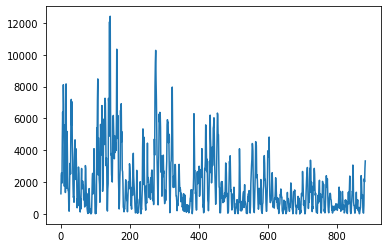

In [ ]:
plt.plot(pspec_df.iloc[5:,0].values)

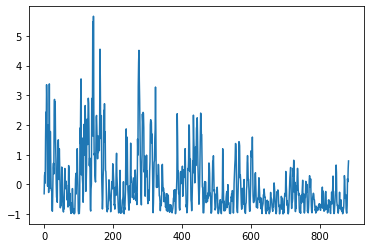

In [ ]:
plt.plot(x[:,0])

In [ ]:
x[:,0].mean()

3.215125501176924e-17

In [ ]:
pca = PCA()

pca.fit(x)

X = pca.transform(x)

pca_df = pd.DataFrame(data = X)
print(pca_df.shape)
pca_df.head()

(884, 884)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883
0,101.876217,-52.042111,107.329228,63.918757,44.908264,-52.168425,-18.440742,-10.363633,5.338283,1.703386,-1.267996,-1.799871,0.560285,-2.702980,-0.502652,2.602594,1.049774,0.811627,0.123294,0.558869,-0.783051,-0.139556,-1.119771,0.532969,0.423014,0.613456,0.276076,-0.474864,1.138110,-0.232798,0.109872,-1.206796,0.577495,1.156065,-0.723197,-0.601707,0.020813,0.217943,1.074041,-0.262776,...,2.016035e-06,2.239183e-06,7.764689e-07,-2.802544e-06,-1.124036e-06,-1.281149e-06,5.457154e-07,3.509067e-07,-4.530021e-07,-1.794437e-06,-3.437555e-07,-1.092316e-06,-1.580620e-06,-2.788830e-07,-1.437001e-07,5.155658e-07,6.593189e-07,-2.041910e-06,4.101800e-07,8.160812e-07,2.885556e-07,-2.393130e-07,-7.647993e-07,1.696322e-07,6.794231e-08,-1.798450e-07,1.479903e-06,-7.316608e-08,-3.313984e-07,-1.958245e-07,-3.444051e-07,1.089309e-07,-2.311008e-07,3.974566e-07,3.656673e-07,-2.153322e-07,-1.290165e-07,-3.335254e-07,-1.660529e-07,1.776357e-15
1,62.036840,-61.373661,55.350314,22.599474,0.463646,76.532357,-7.598137,5.416462,-40.576131,5.198188,-10.469644,-28.071327,24.416148,16.714143,5.822141,-3.358022,-4.235286,-5.254819,5.792298,2.431013,2.410501,0.178780,1.371735,-1.625317,-1.232562,-0.759347,1.260056,1.065632,-0.746714,0.091481,-0.256427,1.003341,-0.760923,-0.536350,0.696272,-0.377856,-1.225821,-0.476443,-0.751390,-0.743329,...,2.707745e-07,3.433519e-06,-2.656778e-06,7.393720e-06,1.646921e-06,-2.178771e-06,1.446944e-07,-1.877641e-07,-1.563260e-06,6.101693e-06,-4.821883e-06,1.219384e-06,1.443507e-06,5.300129e-08,-6.993401e-08,-1.137043e-06,3.606122e-07,2.664649e-06,3.419208e-07,-3.725690e-06,4.121334e-06,2.438627e-06,-3.375174e-07,-1.551448e-06,-1.125479e-08,1.244740e-07,-3.190416e-06,-1.240771e-06,2.138602e-06,1.724848e-07,-5.145218e-07,-9.562017e-07,2.852384e-07,3.175071e-07,4.155678e-07,1.198391e-06,-1.090791e-07,7.292573e-07,3.099815e-08,9.769963e-15
2,56.245534,-64.624166,51.767011,7.650906,-16.598608,53.908038,6.686459,-1.350640,44.298823,-24.290151,-0.186388,44.328816,-22.507822,-24.273289,-2.107952,1.679848,0.750221,-1.177216,-2.603138,-1.499185,-1.182827,1.365148,-0.488779,1.796449,0.484245,-0.531431,-0.118493,1.100539,-0.868198,-1.073081,3.114316,-1.681821,2.094318,-0.613723,-4.208139,-1.744349,0.341671,0.088146,-2.389671,1.112485,...,3.191872e-07,2.464769e-07,6.024628e-07,1.074070e-07,3.588685e-07,4.841452e-07,6.004981e-07,9.061262e-08,1.441188e-06,-5.765273e-07,8.523340e-07,-1.369671e-06,-1.427055e-06,2.083458e-07,-6.097306e-07,-4.719860e-07,-8.480941e-07,3.676879e-07,1.162663e-07,2.584087e-06,-7.931450e-07,-8.843762e-07,5.452819e-07,-2.946810e-07,2.634490e-07,3.776895e-07,-2.154242e-07,-1.551162e-07,-1.778115e-07,5.699274e-08,5.349302e-07,-4.843586e-07,6.147174e-09,-3.567089e-07,4.924733e-07,-1.355966e-07,1.761553e-08,5.306089e-08,4.230364e-08,3.397282e-14
3,75.831015,-53.066032,50.389342,-19.759174,-45.519752,-18.396411,40.584714,46.871410,-1.441524,42.464040,-5.277633,-21.036072,-22.269573,-13.460452,-9.203879,3.916578,-2.115215,-1.576966,-4.156783,-4.408595,-4.159795,3.115772,-3.319546,-0.635843,1.851798,1.230590,2.396211,0.182003,1.386950,0.694974,-2.360262,-0.972051,-0.221060,0.366652,2.945234,1.295447,0.991184,0.103192,0.852854,-0.392690,...,-1.692564e-06,-1.292312e-06,1.997330e-06,-9.097701e-07,2.541743e-06,-4.097447e-07,-1.099802e-06,2.683546e-07,1.476493e-06,6.283681e-07,-2.115244e-07,1.603174e-06,-7.122431e-07,1.793149e-07,-1.421371e-07,-2.184605e-07,3.955209e-07,-9.144694e-07,-1.228414e-06,-2.853947e-07,-3.551525e-07,-2.159563e-07,-2.923197e-07,7.585658e-07,-1.676498e-07,4.904517e-07,3.428414e-07,-5.063299e-07,1.356631e-07,4.184860e-08,3.727317e-07,5.659407e-08,-1.593376e-07,4.644590e-08,-1.041764e-06,-1.545656e-07,-1.632253e-07,-5.638134e-08,2.266433e

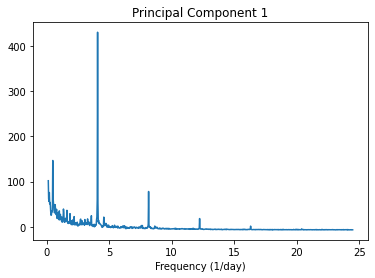

In [ ]:
plt.plot(frequency[5:],pca_df[0])
plt.title('Principal Component 1')
plt.xlabel('Frequency (1/day)')
plt.savefig('pc1.png', bbox_inches = 'tight')

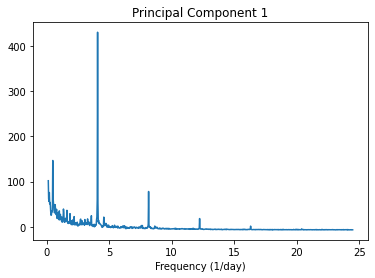

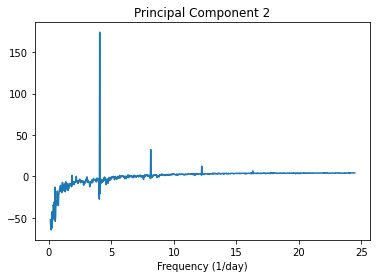

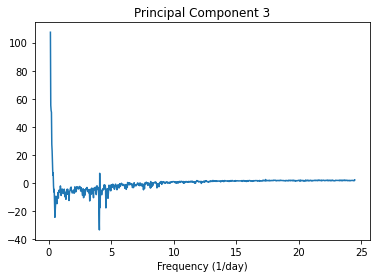

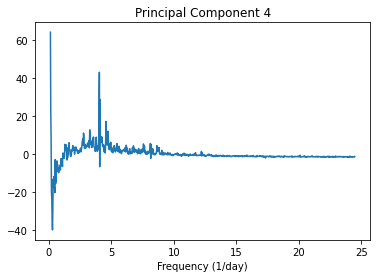

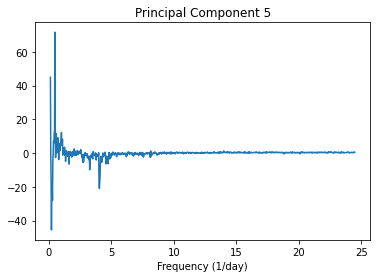

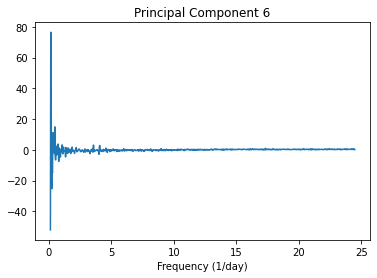

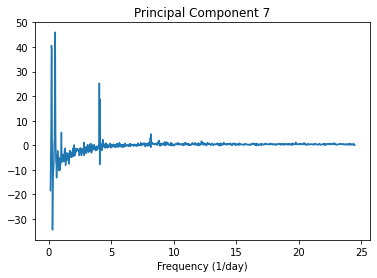

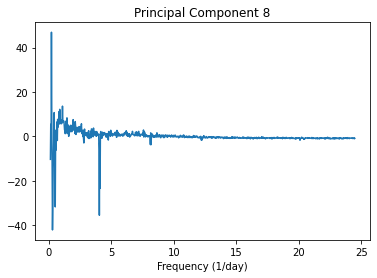

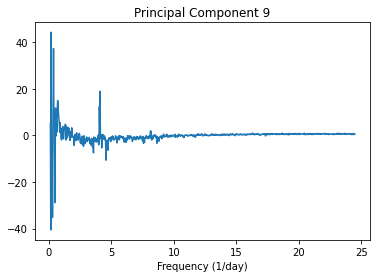

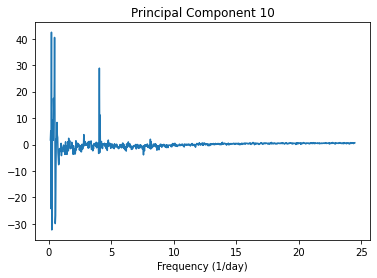

In [ ]:
for i in range(0,10):
  plt.plot(frequency[5:],pca_df[i])
  plt.title('Principal Component {}'.format(i+1))
  plt.xlabel('Frequency (1/day)')
  plt.show()

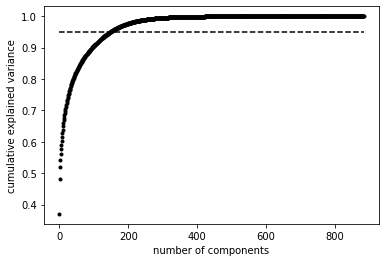

In [ ]:
a = np.arange(0,884)
plt.scatter(a, np.cumsum(pca.explained_variance_ratio_), c='k', marker='.')
plt.plot(a, np.full(len(x),0.95),'k--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.savefig('expvar.png', bbox_inches='tight')

## Method 1: Removing First 2 Components entirely

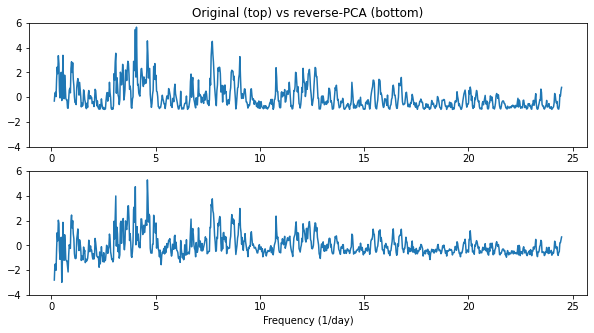

In [ ]:
nComp = 200
Xhat = np.dot(pca.transform(x)[:,2:nComp], pca.components_[2:nComp,:])

fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency[5:],x[:,0])
axes[1].plot(frequency[5:], Xhat[:,0])
axes[0].set_ylim(-4,6)
axes[1].set_ylim(-4,6)


axes[0].set_title('Original (top) vs reverse-PCA (bottom)')
plt.xlabel('Frequency (1/day)')
plt.savefig('pca_compare.png', dpi=100, bbox_inches='tight')

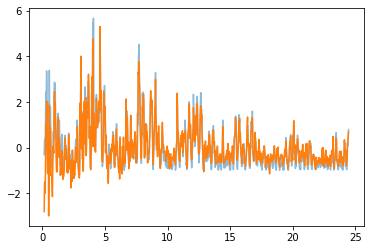

In [ ]:
plt.plot(frequency[5:],x[:,0], alpha=0.5)
plt.plot(frequency[5:], Xhat[:,0]);

## Method 2: Bandpass Filtering First 2 Components

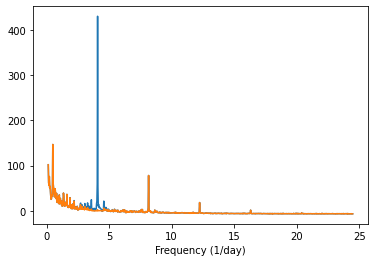

In [ ]:
pca_filtered1 = pca_df[0]*invgaussian(4,1,frequency[5:])
plt.plot(frequency[5:],pca_df[0])
plt.plot(frequency[5:],pca_filtered1)
plt.xlabel('Frequency (1/day)');

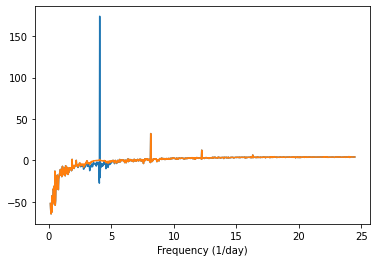

In [ ]:
pca_filtered2 = pca_df[1]*invgaussian(4,1,frequency[5:])
plt.plot(frequency[5:],pca_df[1])
plt.plot(frequency[5:],pca_filtered2)
plt.xlabel('Frequency (1/day)');

In [ ]:
t = np.array([pca_filtered1,pca_filtered2])
filtered_transform = pca.transform(x).copy()
filtered_transform[0:2] = t

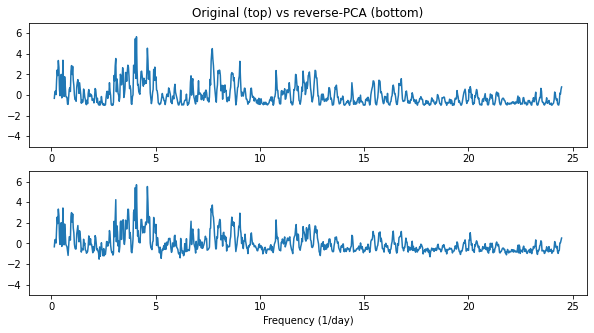

In [ ]:
Xhat1 = np.dot(pca.transform(x)[:,0:nComp], pca.components_[0:nComp,:])

fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency[5:],x[:,0])
axes[1].plot(frequency[5:], Xhat1[:,0])
axes[0].set_ylim(-5,7)
axes[1].set_ylim(-5,7)


axes[0].set_title('Original (top) vs reverse-PCA (bottom)')
plt.xlabel('Frequency (1/day)');

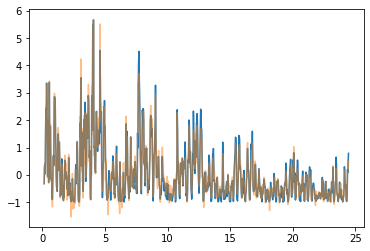

In [ ]:
plt.plot(frequency[5:],x[:,0])
plt.plot(frequency[5:], Xhat1[:,0], alpha=0.5)

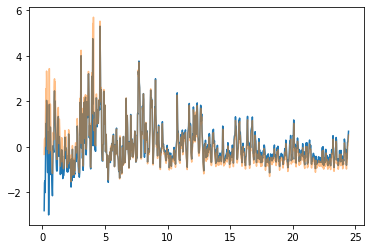

In [ ]:
plt.plot(frequency[5:],Xhat[:,0])
plt.plot(frequency[5:], Xhat1[:,0], alpha=0.5)

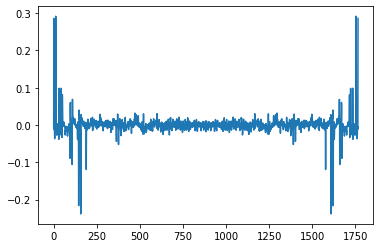

In [ ]:
plt.plot(np.fft.irfft(x[:,0]))

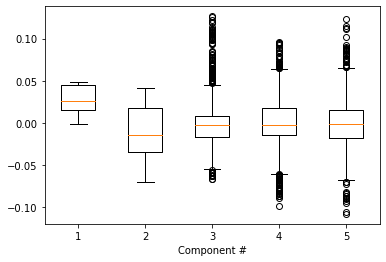

In [ ]:
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot([pca.components_[0], pca.components_[1], pca.components_[2], pca.components_[3],pca.components_[4]])
plt.xlabel('Component #')
plt.show()

## PCA with DFT

In [ ]:
dft_dict = {}


for j, dft in enumerate(dfts):
  dft_dict["dft{0}".format(j)] = dft

dft_df = pd.DataFrame(data=dft_dict)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


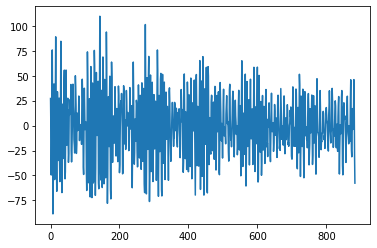

In [ ]:
y = dft_df.loc[5:].values
plt.plot(y[:,0])
y.real = scale(y.real, axis=0)
y.imag = scale(y.imag, axis=0)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


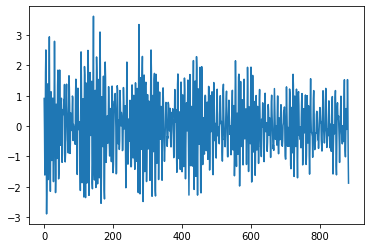

In [ ]:
plt.plot(y[:,0])

In [ ]:
print(y[:,0].real.mean(), y[:,0].imag.mean())

1.0047267191177888e-18 -2.6122894697062506e-17


In [ ]:
print(y[:,0].real.std(), y[:,0].imag.std())

1.0 1.0


In [ ]:
pca.fit(y.real)

Y = pca.transform(y.real)

pca2_df = pd.DataFrame(data = Y)
print(pca2_df.shape)
pca2_df.head()

(884, 884)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883
0,7.799226,-17.183759,6.594181,-20.846641,-17.652041,14.603317,6.839582,53.576197,41.171624,26.019796,25.314404,25.254215,-3.284111,48.022443,27.008749,-25.644993,-6.376325,1.147538,-18.043564,-10.043612,3.802648,9.247050,-6.729998,7.945714,-5.081960,-5.053152,-0.219757,-3.829830,-4.321292,-2.251154,2.569438,2.194177,-4.462076,1.388697,-2.390190,-2.666941,-2.346472,-0.144730,0.349903,2.266155,...,-0.000127,-0.000287,0.000522,0.000213,0.000061,-0.000318,0.000333,0.000083,-0.000377,0.000274,-0.000067,0.000165,-0.000494,0.000155,-0.000073,-0.000167,-0.000139,0.000108,0.000163,0.000124,-0.000138,-0.000088,-0.000098,0.000107,-0.000038,-0.000212,0.000063,-0.000090,-0.000284,-0.000238,-0.000054,-4.287118e-04,-0.000048,-0.000106,-0.000145,0.000070,-0.000012,-0.000097,-0.000022,-3.330669e-16
1,6.729120,-10.642435,-5.460095,-13.357592,-2.422508,24.584705,-8.039382,10.741008,26.086652,22.008545,-3.164983,46.580367,-7.225148,-5.497778,-26.003651,42.086940,25.252584,28.365596,14.525996,4.896890,-18.820904,-2.633812,6.893655,17.894156,17.534090,-1.244080,0.950616,-0.961960,-3.782621,3.328444,-0.229827,2.466531,2.256919,-1.024532,-3.632642,2.030462,2.572939,1.902525,1.609024,0.127712,...,-0.000334,0.000206,-0.000311,-0.000136,-0.000455,-0.000255,0.000485,-0.000443,-0.000202,0.000142,0.000527,-0.000278,0.000394,0.000543,0.000072,-0.000151,0.000234,0.000196,0.000293,0.001010,0.000283,-0.000681,0.000603,-0.000230,0.000188,0.000044,0.000306,0.000178,0.000397,0.000209,-0.000240,-6.400410e-05,-0.000048,0.000501,-0.000299,0.000456,0.000003,0.000066,0.000009,6.716849e-15
2,-48.135577,-1.342193,5.754565,16.269163,-14.971094,27.731308,-14.102964,2.744563,47.486473,-3.926585,-3.360533,-10.498503,-15.727165,-14.466517,21.103174,1.419694,-13.700952,-5.695049,12.775329,-17.243741,-7.960194,-4.321448,35.818988,-11.342892,2.451719,38.623920,-10.136682,2.274061,-4.134778,0.679348,-4.919644,4.111684,-6.105874,-5.781075,2.425454,1.576110,-2.238745,0.986338,-2.432231,-4.671547,...,-0.001125,0.000317,-0.000475,-0.000225,-0.000486,-0.000291,-0.000069,-0.000386,-0.000030,-0.000656,-0.000635,-0.000704,-0.000138,-0.000232,-0.000052,0.000165,-0.000150,-0.000268,0.000034,-0.000322,0.000145,0.000310,-0.000113,-0.000033,0.000266,0.000065,-0.000355,0.000087,-0.000192,-0.000256,0.000017,9.798423e-05,0.000221,0.000127,-0.000363,0.000155,0.000124,0.000159,0.000067,-1.887379e-15
3,7.636076,5.478273,10.964307,-16.586674,-2.875682,33.920310,-5.940027,-21.024699,39.037128,20.915800,7.663995,-21.546156,1.089426,0.818753,-9.468828,-26.475973,6.287798,-4.672829,15.573964,53.975468,-6.548639,-9.171954,-17.718375,-16.117382,15.594748,2.585200,-4.395283,-2.887020,1.164381,-2.352496,0.824383,-2.823630,-4.189714,2.384501,-1.877387,-1.960672,-1.520447,-3.355312,0.894591,-0.079002,...,-0.000214,-0.000265,0.000329,-0.000102,0.000030,0.000042,0.000123,0.000305,-0.000182,0.000036,0.000730,-0.000006,-0.000485,0.000308,-0.000391,-0.000170,-0.000062,0.000120,-0.000030,0.000169,0.000024,-0.000223,-0.000414,0.000193,-0.000008,-0.000147,0.000004,-0.000267,-0.000083,0.000129,-0.000209,1.513581e-04,-0.000254,0.000060,-0.000034,-0.000240,-0.000128,0.000045,-0.000021,1.396105e-14
4,3.982190,31.650907,3.589142,32.369755,-3.871841,-7.796209,11.388866,36.422647,-6.244983,-16.978873,-4.816300,11.901371,4.760250,-4.774512,2.295368,12.109626,-15.546331,-4.251689,-18.745831,37.389344,28.148167,-27.627335,24.226868,12.758495,7.193316,-4.809910,-9.553661,2.642249,-10.772385,-8.783101,-0.835403,-1.262526,-14.172652,4.010945,-6.233230,-2.239803,3.036071,0.255264,3.864030,0.671322,...,-0.000081,0.000040,0.000206,0.000089,0.000270,-0.000174,0.000456,0.000121,-0.000114,0.000422,0.000356,0.000795,-0.000035,0.000005,-0.000120,-0.000256,0.000022,0

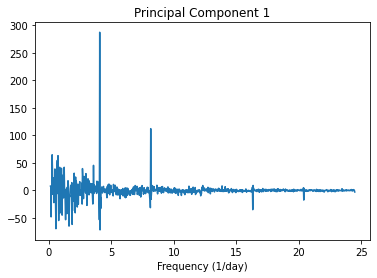

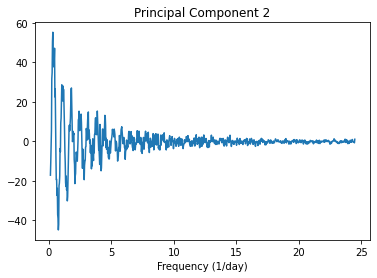

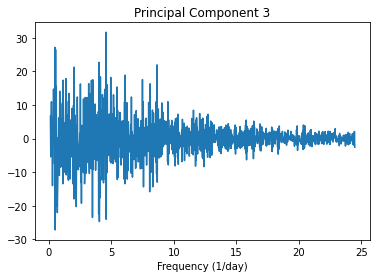

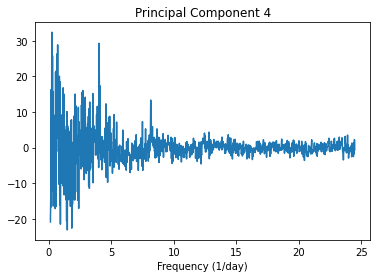

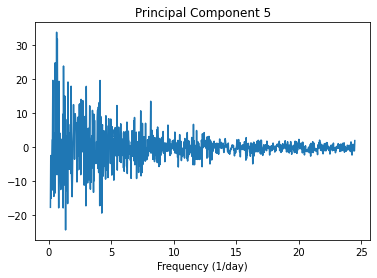

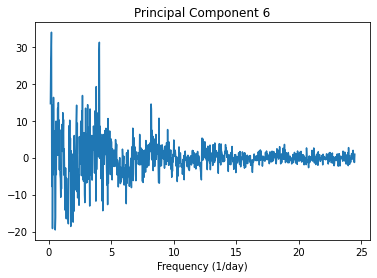

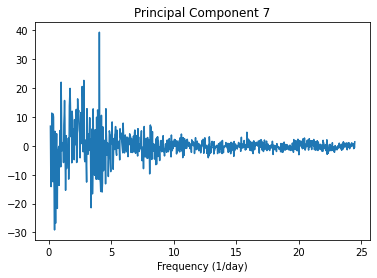

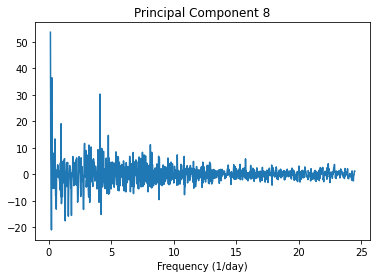

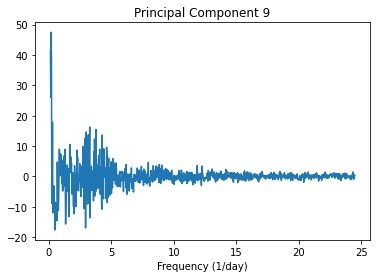

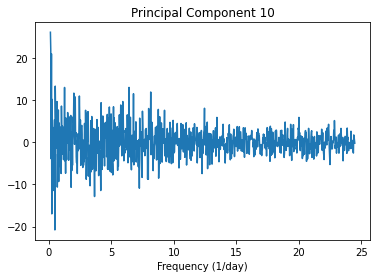

In [227]:
for i in range(0,10):
  plt.plot(frequency[5:],pca2_df[i])
  plt.title('Principal Component {}'.format(i+1))
  plt.xlabel('Frequency (1/day)')
  plt.show()

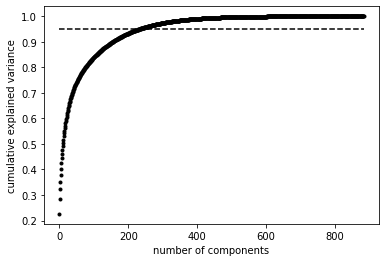

In [ ]:
a = np.arange(0,884)
plt.scatter(a, np.cumsum(pca.explained_variance_ratio_), c='k', marker='.')
plt.plot(a, np.full(len(x),0.95),'k--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.savefig('expvar.png', bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


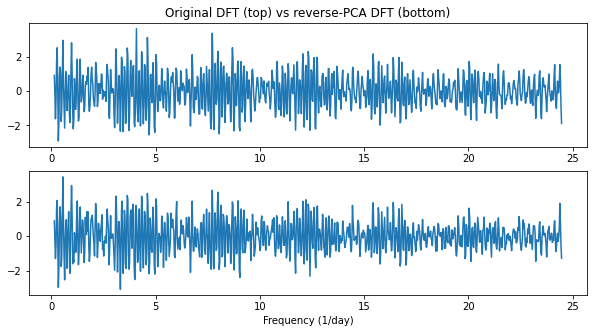

In [229]:
nComp = 200
Yhat = np.dot(pca.transform(y.real)[:,2:nComp], pca.components_[2:nComp,:])

fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency[5:],y[:,0])
axes[1].plot(frequency[5:], Yhat[:,0])
#axes[0].set_ylim(-4,6)
#axes[1].set_ylim(-4,6)


axes[0].set_title('Original DFT (top) vs reverse-PCA DFT (bottom)')
plt.xlabel('Frequency (1/day)')
plt.savefig('pca2_compare.png', dpi=100, bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


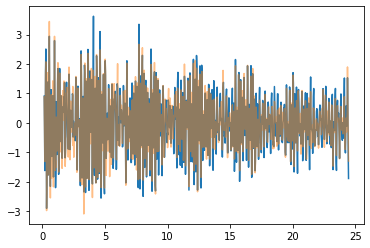

In [230]:
plt.plot(frequency[5:],y[:,0])
plt.plot(frequency[5:], Yhat[:,0],alpha=0.5)

In [ ]:
Yhatc = Yhat + (1j)*y.imag
Yhatc

array([[ 8.84440423e-01+7.46876917e-01j,  5.43851237e-01-9.74442696e+00j,
         1.85902816e+00-9.20890242e+00j, ...,
        -4.21096982e-01+4.14973946e+00j,  2.11528064e+00-1.11119828e+00j,
        -7.47973277e-01-1.82097118e+00j],
       [-1.56339102e-01-1.60379450e+00j,  2.17714219e+00-6.16646622e+00j,
        -2.30409795e-01-4.82890052e-01j, ...,
         4.83536393e-02-3.67912144e+00j,  1.54112779e-01+7.15315522e-01j,
         9.28932484e-01+2.04786055e+00j],
       [-1.30426445e+00-3.83459148e-01j,  2.78527489e+00-6.33214358e+00j,
        -6.22323522e-01-1.48541173e+00j, ...,
         9.30965423e-01+1.62850849e+00j, -8.02914012e-01-3.42202149e+00j,
        -1.68779931e+00-1.24170899e+00j],
       ...,
       [ 7.75685866e-01-1.29677000e+00j, -2.73724852e-01+2.30817362e-01j,
         4.16118860e-02+2.30855043e-01j, ...,
        -2.85453089e-01-4.72316082e-01j, -2.50020592e-03-1.39311856e-01j,
         2.12338557e-01+2.39335730e-01j],
       [-5.70041304e-01-1.47018539e+00j,  5.

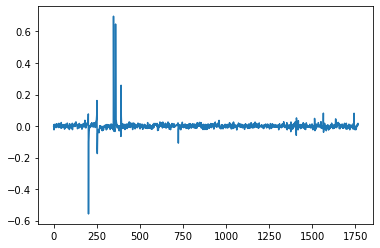

In [ ]:
plt.plot(np.fft.irfft(Yhatc[:,0]));

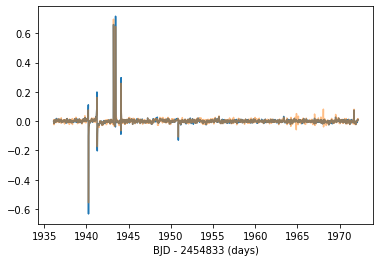

In [ ]:
plt.plot(bjds[0][10:],np.fft.irfft(y[:,0]))
plt.plot(bjds[0][10:],np.fft.irfft(Yhatc[:,0]), alpha=0.5)
plt.xlabel('BJD - 2454833 (days)')
plt.savefig('dftpca.png', dpi=100, bbox_inches='tight')